# CNN Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* I had trouble figuring out the inputs for the Embedding layer if we used word2vec embedding so using review_body-bow-df_default-ngram12-111909-10020-lda20 instead of word 2 vec since we need to create an embedding layer
* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from util import dict_util as du
from util import file_util as fu
from util import plot_util as pu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os

Using TensorFlow backend.


In [2]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_DIR = "dataset/feature_files"
DATA_FILE = "review_body-bow-df_default-ngram12-50000-10020-lda20.csv"
MODEL_NAME = "CNN"
FEATURE_COLUMN = "star_rating"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{FEATURE_COLUMN}"
MODEL_FILE = f"models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"reports/2019-06-18-NN_notebook_protype-report.csv"

In [3]:
df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")

In [4]:
rating = df[FEATURE_COLUMN]
df = df.drop(columns=["helpful_votes", "total_votes",  "star_rating"])

In [5]:
df.head()

,aa,aaa,ability,able,able charge,able do,able find,able get,able hear,able keep,...,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,...,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.330576,0.405078,0.002083,0.002083
1,0,0,0,0,0,0,0,0,0,0,...,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.620561,0.002778,0.002778
2,0,0,0,0,0,0,0,0,0,0,...,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.548134,0.002632,0.002632,0.002632
3,0,0,0,0,0,0,0,0,0,0,...,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.206143,0.002778
4,0,0,0,0,0,0,0,0,0,0,...,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,0.173658


In [6]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [7]:
model = Sequential()
model.add(Embedding(df.shape[1], 1024, input_length=df.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10020, 1024)       10260480  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10020, 32)         98336     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5010, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160320)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               40080250  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total params: 50,440,321
Trainable params: 50,440,321
Non-trainable params: 0
________________________________________________________________

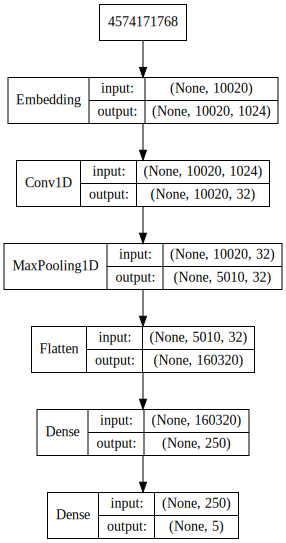

In [9]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [10]:
# one hot encode rating
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(50000,)
<class 'pandas.core.series.Series'>


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=1)

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=2,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 30000 samples, validate on 7500 samples
Epoch 1/2
30000/30000 [==============================] - 25371s 846ms/step - loss: 6.7841 - acc: 0.5791 - val_loss: 6.8534 - val_acc: 0.5748
Epoch 2/2
30000/30000 [==============================] - 20848s 695ms/step - loss: 6.7841 - acc: 0.5791 - val_loss: 6.8534 - val_acc: 0.5748


In [28]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


12500/12500 [==============================] - 850s 68ms/step
Accuracy: 56.90%


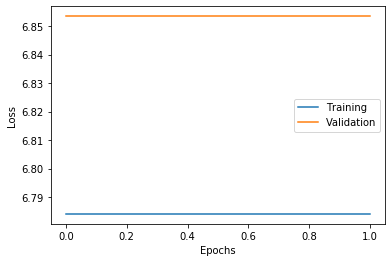

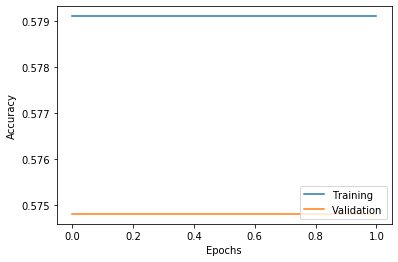

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [30]:
y_predict = model.predict(x_test)

In [31]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0


In [32]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [33]:
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]

In [34]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[   0,    0,    0,    0, 1635],
       [   0,    0,    0,    0,  742],
       [   0,    0,    0,    0, 1017],
       [   0,    0,    0,    0, 1994],
       [   0,    0,    0,    0, 7112]])

In [35]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1635
           2       0.00      0.00      0.00       742
           3       0.00      0.00      0.00      1017
           4       0.00      0.00      0.00      1994
           5       0.57      1.00      0.73      7112

    accuracy                           0.57     12500
   macro avg       0.11      0.20      0.15     12500
weighted avg       0.32      0.57      0.41     12500



/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Save off various files

In [36]:
model.save(MODEL_FILE)

In [37]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [38]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["embedding"] = "bow"
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = x_test.shape[0]
flattened["test_features"] = x_test.shape[1]
flattened["train_examples"] = x_train.shape[0]
flattened["train_features"] = x_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head()



,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,status,test_examples,test_features,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,status_date
0,0.684016,0.579598,0.834323,3875,0.102234,0.269841,0.063063,1887,0.254482,0.350962,...,success,27978,512,83931,512,0.626187,0.614808,0.667024,27978,NaN
1,0.686399,0.582778,0.834839,3875,0.061751,0.236749,0.035506,1887,0.281108,0.335683,...,success,27978,512,83931,512,0.623634,0.612376,0.667489,27978,6/19/19 16:41
2,0.691544,0.619885,0.781935,3875,0.115930,0.272016,0.073662,1887,0.234400,0.356459,...,success,27978,512,83931,512,0.619603,0.605619,0.664844,27978,6/19/19 17:02
3,0.000000,0.000000,0.000000,1635,0.000000,0.000000,0.000000,742,0.000000,0.000000,...,success,12500,10020,37500,10020,0.412650,0.323715,0.568960,12500,2019-06-20 03:57:34
4,0.000000,0.000000,0.000000,1635,0.000000,0.000000,0.000000,742,0.000000,0.000000,...,success,12500,10020,37500,10020,0.412650,0.323715,0.568960,12500,2019-06-20 20:27:18


In [40]:
report_df.to_csv(REPORT_FILE, index=False)